READ IN DATA

In [1]:
import numpy as np
import pandas as pd
import glob
labelids = pd.read_csv("group_labels.csv",sep=',')
print(labelids.head())
LABELS = list(labelids)[1:]
print(LABELS)


           dish_id  Meat  Nuts/seeds  Eggs  Beans/lentils/peas  Fruit  Grain  \
0  dish_1562688426   1.0         0.0   0.0                 0.0    0.0    0.0   
1  dish_1561662054   1.0         0.0   0.0                 0.0    1.0    1.0   
2  dish_1560455030   0.0         0.0   0.0                 0.0    0.0    0.0   
3  dish_1565640549   0.0         0.0   0.0                 0.0    1.0    0.0   
4  dish_1563207364   0.0         0.0   1.0                 0.0    1.0    0.0   

   Vegetables  Dairy  
0         1.0    0.0  
1         1.0    0.0  
2         1.0    0.0  
3         1.0    0.0  
4         1.0    0.0  
['Meat', 'Nuts/seeds', 'Eggs', 'Beans/lentils/peas', 'Fruit', 'Grain', 'Vegetables', 'Dairy']


In [5]:
from os.path import exists
import random

train_paths = []
test_paths = []
with open("5koverhead/trainids.txt") as f:
    train_set = set(f.read().splitlines())
with open("5koverhead/testids.txt") as f:
    test_set = set(f.read().splitlines())

for fileid in labelids['dish_id'].to_numpy():
    path = f"5koverhead/Images/realsense_overhead/{fileid}/rgb.png"
    if(exists(path)):
        if(fileid in test_set):
            test_paths.append(path)
        else:
            train_paths.append(path)

labels_db = pd.read_csv("../labels.csv")
labels_db = labels_db.astype({'filename': 'string'})
for im_path in glob.glob("../FoodSeg103/Images/ann_dir/train/*.png"):
    fileid = im_path.split("/")[-1].split(".")[0]+".jpg"
    if fileid in labels_db['filename'].to_numpy():
        jpg_path = "../FoodSeg103/Images/img_dir/train/" + fileid
        train_paths.append(jpg_path)
for im_path in glob.glob("../FoodSeg103/Images/ann_dir/test/*.png"):
    fileid = im_path.split("/")[-1].split(".")[0]+".jpg"
    if fileid in labels_db['filename'].to_numpy():
        jpg_path = "../FoodSeg103/Images/img_dir/test/" + fileid
        test_paths.append(jpg_path)
print(labels_db.head())
print(len(train_paths))
print(len(test_paths))

random.shuffle(train_paths)
random.shuffle(test_paths)
print("Size of training set: " ,len(train_paths))
print("Size of test set: " ,len(test_paths))

       filename  Meat  Nuts/seeds  Eggs  Beans/lentils/peas  Fruit  Grain  \
0  00000000.jpg     1           0     0                   0      0      1   
1  00000001.jpg     0           0     0                   0      0      0   
2  00000002.jpg     0           0     0                   0      0      1   
3  00000003.jpg     1           0     0                   0      0      0   
4  00000004.jpg     1           0     0                   0      0      0   

   Vegetables  Dairy  
0           1      0  
1           1      0  
2           0      0  
3           1      0  
4           1      0  
7059
2445
Size of training set:  7059
Size of test set:  2445


Convert to tensorflow dataset

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

IMG_WIDTH, IMG_HEIGHT = 224 , 224
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

ds_train = tf.data.Dataset.from_tensor_slices(train_paths)
ds_test = tf.data.Dataset.from_tensor_slices(test_paths)

2022-06-28 12:55:33.011769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 12:55:37.698277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7984 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2022-06-28 12:55:37.704212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11433 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2022-06-28 12:55:37.704963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/d

In [7]:
# CATEGORY_INDEX = 8
# print(LABELS[CATEGORY_INDEX])
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    file_name= parts[-2].numpy().decode('utf-8')
    if(file_name[0] == "d"):
      numpy_array = labelids.loc[labelids['dish_id'] == file_name][LABELS].to_numpy().astype('int64')
      l = tf.convert_to_tensor(np.squeeze(numpy_array))
    else:
      parts = tf.strings.split(file_path, '/')
      file_name= parts[-1].numpy().decode('utf-8')
      numpy_array = labels_db.loc[labels_db['filename'] == file_name][LABELS].to_numpy().astype('int64')
      l = tf.convert_to_tensor(np.squeeze(numpy_array))
    return l

def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
BATCH_SIZE=64
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)
          
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())

Number of batches in train:  111
Number of batches in test:  39


In [6]:
import re

# x_labels = [re.sub("[\(\[].*?[\)\]]", "", x) for x in LABELS]
# np_histogram_train = np.zeros(len(LABELS))
# np_histogram_test = np.zeros(len(LABELS))
# for a,b in ds_train:
#     np_histogram_train = np.add(np_histogram_train, b.numpy())
# np_histogram_test = np.zeros(len(LABELS))
# for a,b in ds_test:
#     np_histogram_test = np.add(np_histogram_test, b.numpy())

In [7]:
# print(np_histogram_train)
# fig=plt.figure(figsize=(20, 10))
# plt.bar(x_labels, np_histogram_train)

In [8]:
# print(np_histogram_test)
# fig=plt.figure(figsize=(20, 10))
# plt.bar(x_labels, np_histogram_test)

9 samples
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)
(8,)
(224, 224, 3)


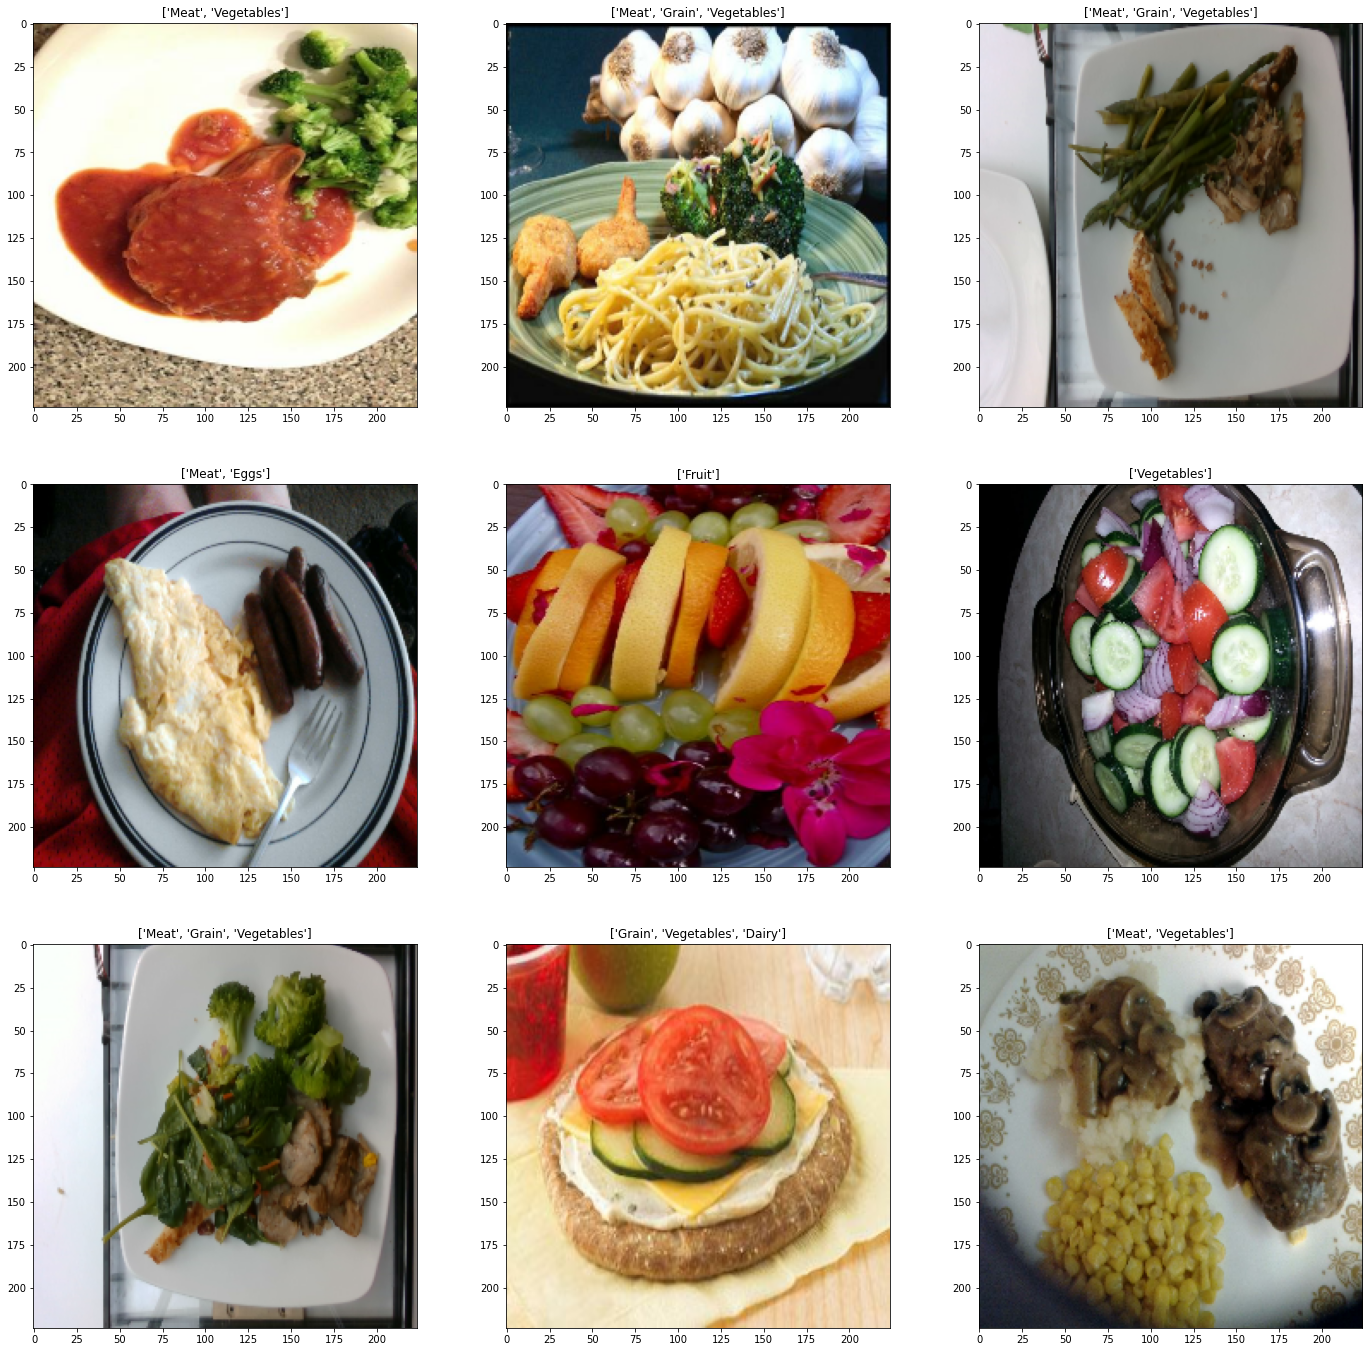

In [9]:
def convert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in enumerate(label_string):
     if label_onehot[i]:
       labels.append(re.sub("[\(\[].*?[\)\]]", "", label))
  if len(labels)==0:
    labels.append("NONE")
  return labels
def show_samples(dataset):
  fig=plt.figure(figsize=(24, 24))
  columns = 3
  rows = 3
  print(columns*rows,"samples")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title(str(convert_onehot_string_labels(LABELS,b.numpy())))
    print(b.numpy().shape)
    print(a.shape)
    i=i+1
  plt.show()
show_samples(ds_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


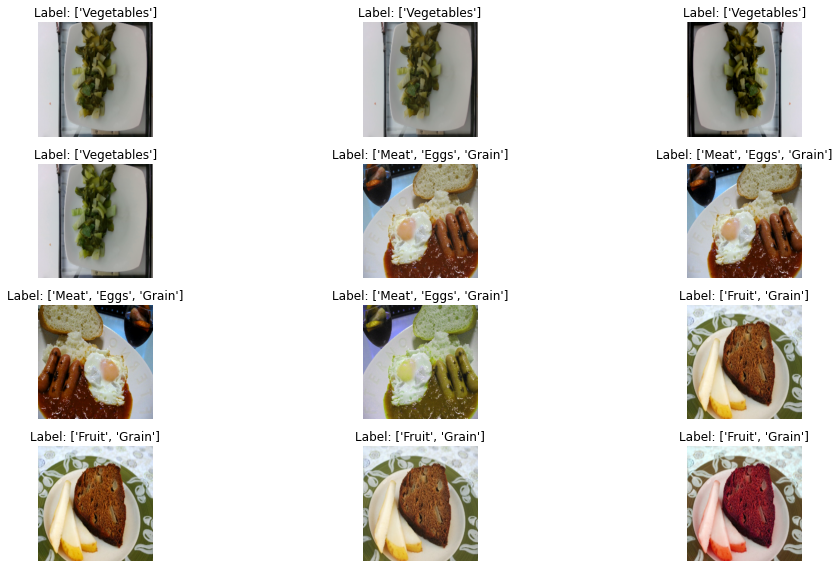

In [10]:
def augment_data(x, y, repeat_count=3):
  images = []
  ys=[]
  images.append(x)
  ys.append(y)
  for i in range(repeat_count-1):
    augmented_image = tf.image.random_brightness(x, 0.1)
    augmented_image = tf.image.random_contrast(augmented_image, .8, 1.2)
    augmented_image = tf.image.random_saturation(augmented_image, 0.85, 1.15)
    augmented_image = tf.image.random_flip_left_right(augmented_image)
    images.append(augmented_image)
    ys.append(y)
  images.append(tf.image.random_hue(x,0.1))
  ys.append(y)
  return images, ys
ds_train = ds_train.map(augment_data)
ds_train = ds_train.unbatch()
plt.figure(figsize=(16, 8)) 
for i, (x, y) in enumerate(ds_train.take(12)):
  plt.subplot(4, 3,i+1)
  plt.title('Label: {}'.format(convert_onehot_string_labels(LABELS, y.numpy())))
  plt.axis('off')
  plt.imshow(x.numpy())
plt.tight_layout()

In [11]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())

Number of batches in train:  -2
Number of batches in test:  39


In [12]:
tf.test.is_gpu_available()
mirrored_strategy = tf.distribute.MirroredStrategy()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-06-25 02:40:15.241830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 7984 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2022-06-25 02:40:15.242228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:1 with 1778 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
2022-06-25 02:40:15.242599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:2 with 3027 MB memory:  -> device: 2, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:83:00.0, compute capability: 6.1
2022-06-25 02:40:15.242976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:3 with 11433 MB memory:  -> device: 3, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:84:00.0, compute capability: 6.1


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [16]:
number_of_classes = len(LABELS)

# with mirrored_strategy.scope():
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                            kernel_initializer=initializer,
                            activation=activation)(x) 
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(0.02),
            loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
            metrics=[keras.metrics.BinaryAccuracy()])

In [17]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
# options = tf.data.Options()
# options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# ds_train_batched = ds_train_batched.with_options(options)
# ds_test_batched = ds_test_batched.with_options(options)
history = model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=100)

Epoch 1/100


2022-06-25 02:40:24.973260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


442/442 [==============================] - 284s 627ms/step - loss: 0.4965 - binary_accuracy: 0.7556 - val_loss: 0.4910 - val_binary_accuracy: 0.7638
Epoch 2/100
442/442 [==============================] - 67s 152ms/step - loss: 0.4828 - binary_accuracy: 0.7647 - val_loss: 0.4846 - val_binary_accuracy: 0.7685
Epoch 3/100
442/442 [==============================] - 63s 143ms/step - loss: 0.4775 - binary_accuracy: 0.7680 - val_loss: 0.4816 - val_binary_accuracy: 0.7719
Epoch 4/100
442/442 [==============================] - 62s 141ms/step - loss: 0.4739 - binary_accuracy: 0.7703 - val_loss: 0.4798 - val_binary_accuracy: 0.7738
Epoch 5/100
442/442 [==============================] - 63s 143ms/step - loss: 0.4712 - binary_accuracy: 0.7719 - val_loss: 0.4786 - val_binary_accuracy: 0.7749
Epoch 6/100
442/442 [==============================] - 61s 139ms/step - loss: 0.4690 - binary_accuracy: 0.7731 - val_loss: 0.4778 - val_binary_accuracy: 0.7748
Epoch 7/100
442/442 [==============================

KeyboardInterrupt: 

In [ ]:
# Unfreeze the base model
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(3e-6),
            loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
            metrics=[keras.metrics.BinaryAccuracy()])
# Train end-to-end. Be careful to stop before you overfit!
model.fit(ds_train_batched, epochs=10, validation_data=ds_test_batched)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/8


2022-06-24 14:42:25.719866: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


111/111 [==============================] - 59s 459ms/step - loss: 0.4417 - binary_accuracy: 0.7832 - val_loss: 0.4551 - val_binary_accuracy: 0.7755
Epoch 2/8
111/111 [==============================] - 50s 448ms/step - loss: 0.4331 - binary_accuracy: 0.7883 - val_loss: 0.4541 - val_binary_accuracy: 0.7765
Epoch 3/8
111/111 [==============================] - 50s 448ms/step - loss: 0.4284 - binary_accuracy: 0.7912 - val_loss: 0.4523 - val_binary_accuracy: 0.7786
Epoch 4/8
111/111 [==============================] - 50s 448ms/step - loss: 0.4244 - binary_accuracy: 0.7940 - val_loss: 0.4534 - val_binary_accuracy: 0.7788
Epoch 5/8
111/111 [==============================] - 49s 444ms/step - loss: 0.4206 - binary_accuracy: 0.7964 - val_loss: 0.4553 - val_binary_accuracy: 0.7799
Epoch 6/8
111/111 [==============================] - 50s 448ms/step - loss: 0.4173 - binary_accuracy: 0.7995 - val_loss: 0.4541 - val_binary_accuracy: 0.7810
Epoch 7/8
111/111 [==============================] - 50s 447ms

In [ ]:
file_path = "../model/ResNet50_combined_dataset.h5"
model.save(file_path)

In [ ]:
predictions= model.predict(ds_test.batch(1))

np_acc = np.zeros(len(LABELS))
print(np_acc)
print("sample prediction: ", predictions[0])
for (pred,(a,b)) in zip(predictions,ds_test):
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    np_acc = np.add(pred == b.numpy().squeeze(), np_acc)
np_acc = np_acc/len(predictions)
c = 0
for l in LABELS:
    print(f"Accuracy of {l}: {np_acc[c]}")
    c = c+1
print(np.average(np_acc))

In [ ]:
ds_sample = ds_test.batch(batch_size=1).take(9)
predictions= model.predict(ds_sample)
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("9 Sample predictions:")
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 3
print(columns*rows,"samples")
i=1
for (pred,(a,b)) in zip(predictions,ds_sample):
      pred[pred>0.5]=1
      pred[pred<=0.5]=0
      fig.add_subplot(rows, columns, i)
      plt.imshow(np.squeeze(a))
      plt.title("predicted: " + str(convert_onehot_string_labels(LABELS, pred))+  
            "\nActual Label: ("+str(convert_onehot_string_labels(LABELS,b.numpy().squeeze())) +")")
      i=i+1
      y.append(b.numpy())

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()